## Active-Passive Simulation Code Checks
### Stephen Williams

This file will load in the code for the data from the simulation outputs and then perform a series of checks to ensure that the output data is sensible.

The simulation is designed to output the active and passive co-ordinates every 50 time-steps for some $dt$.

In [138]:
import numpy as np
import matplotlib.pyplot as plt

First step is to load in all the data from a short run

In [120]:
active_data = np.loadtxt("/Users/steve/Library/CloudStorage/GoogleDrive-stev3.w1l@gmail.com/My Drive/Academia/q_projects_personal/a_AP_scattering/simulation_code/outputs/output_active.txt",delimiter=' ',skiprows=1000)
passive_data = np.loadtxt("/Users/steve/Library/CloudStorage/GoogleDrive-stev3.w1l@gmail.com/My Drive/Academia/q_projects_personal/a_AP_scattering/simulation_code/outputs/output_passive.txt",delimiter=' ',skiprows=1000)

Display some potion of each dataset to show it loaded in correctly...

In [121]:
print(active_data[0:3,:])
print(passive_data[0:3,:])

[[ 1.20000e+03  1.00000e+00  1.10333e+01  3.44025e+00  2.64366e+00
   0.00000e+00]
 [ 1.20000e+03  2.00000e+00 -6.31776e+00  4.77613e+00  5.68711e+00
   0.00000e+00]
 [ 1.20000e+03  3.00000e+00 -1.09936e+01  3.13086e+00  3.56817e+00
   0.00000e+00]]
[[ 1.20000e+03  1.00000e+00  3.96627e+01 -2.80576e+00  0.00000e+00]
 [ 1.20000e+03  2.00000e+00  4.43533e+00 -6.03617e+00  0.00000e+00]
 [ 1.20000e+03  3.00000e+00  1.68257e+00  9.25951e-01  0.00000e+00]]


Here, we can see the active data has 6 entries per particle, per timestep. These are: [time-step index, particle index, x-coordinate, y-coordinate, orientation, boolean non-zero force].
Similarly, the passive has [time-step index, particle index, x-coordinate, y-coordinate, and the boolean]. The orientation is ommitted due to their symmetry.

Next, we will plot the trajectories of all of the particles in the system for some limited window to give a sense of the difference in the motion types.

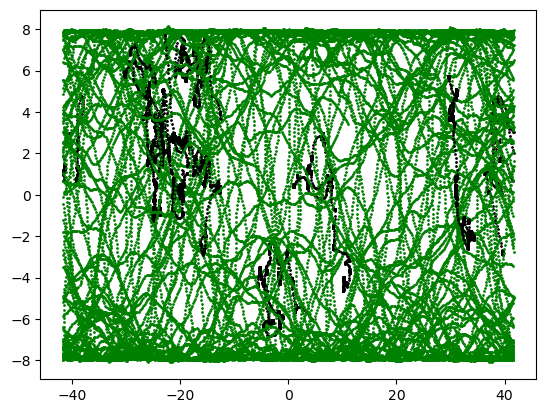

In [137]:
plt.figure()
active_indicies = np.unique(active_data[:,1])
passive_indicies = np.unique(passive_data[:,1])

for ind in active_indicies:
    if ind < 10:
        plt.scatter(active_data[active_data[:,1] == ind,2],active_data[active_data[:,1] == ind,3],1,'g')
        plt.scatter(passive_data[passive_data[:,1] == ind,2],passive_data[passive_data[:,1] == ind,3],1,'k')

We will not calculate for each of the passive particles along the trajectory their velocity as a function of time. To do this we will take the first order approxiamation:
$\bold{v}(t) = |\bold{r}(t+1)-\bold{r}(t)|/\Delta{t}$

Percentage of data unaltered: 0.9993396226415093
Fastest detected speed is 149.65095999638706 um/s$


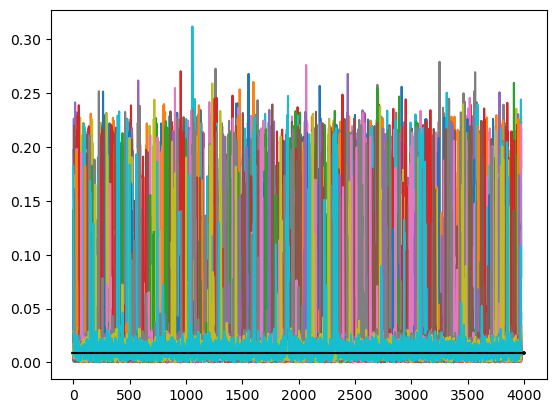

In [174]:
passive_indicies = np.unique(passive_data[:,1])
ma = 0.
V = np.zeros(len(passive_indicies))
dt = 5e-4
thresh = 1.1*100*dt*50/12

for ind,val in enumerate(passive_indicies):

    x_dat = passive_data[passive_data[:,1] == val,2]
    y_dat = passive_data[passive_data[:,1] == val,3]

    dx = x_dat[1:] - x_dat[:-1]
    dy = y_dat[1:] - y_dat[:-1]

    for ind_displacement,values in enumerate(dx):
        while np.abs(dx[ind_displacement]) >= (1000./12.)-5.:
            dx[ind_displacement] -= np.sign(dx[ind_displacement])*1000./12.
    dx[abs(dx)>thresh] = 0 # Ask that colliods dont move faster than the actives (+20%)
    
    # for ind_displacement,values in enumerate(dy):
    #     while np.abs(dy[ind_displacement]) >= (200./12.)-5.:
    #         dy[ind_displacement] -= np.sign(dy[ind_displacement])*200./12.
    dy[abs(dy)>thresh] = 0 # Ask that colliods dont move faster than the actives (+20%)

    #print(f"{1-(len(dy[dy==0])/len(dy))} proportion of data used")

    dr = np.sqrt(dy**2 + dx**2)

    V[ind] = 1-(len(dy[dy==0])/len(dy))
    #V[ind] = np.mean(dr[:])*12//(2.5e-5*50)

    ma = np.max( [ma, np.max(dr)] )

    plt.plot(dr)
    plt.plot(np.linspace(0,4000,100),np.sqrt(4*(0.1/144)*(50*dt))*np.ones(100),'k')

print(f"Percentage of data unaltered: {np.mean(V)}")
print(f"Fastest detected speed is {ma*12/(dt*50)} um/s$")
print(f"Black line shows the expected displacement from diffusion")


We can see that, 99.93396% of the instantaneous displacement speeds in this case are below $1.5 v_s, the swimmer velocity (during 50 steps).

Now, we can use the formaulation from $\textit{Mosby, et. al.}$ to figure out when the trajectory is "more-correlated" than we would expect for a Brownian Trajectory.

In the below example 1 trajectory will be analysed.

[1. 1. 1. ... 1. 0. 0.]


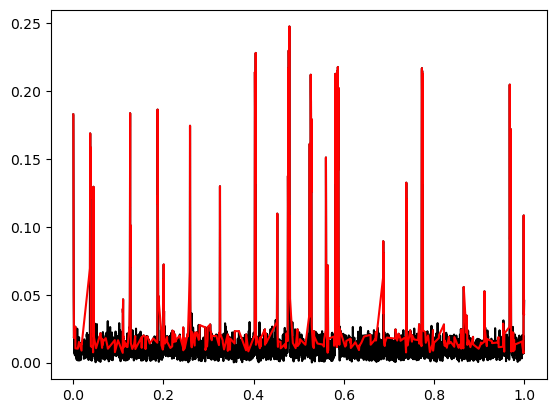

In [170]:
dr = np.transpose(np.array([dx,dy]))
p = np.zeros(len(dx)-1)
isJump = np.zeros([len(dx),4])
isJump[:,0:2] = dr
isJump[:,3] = np.linspace(0,1,len(dx))

for ind,val in enumerate(dx[:-1]):
    p[ind] = dx[ind-1]*dx[ind] + dy[ind-1]*dy[ind]

q = (p[1:] + p[:-1])/2

Dtherm = 0.1
D0 = Dtherm*(50*dt)/12**2
thresh = 2*np.sqrt(8)*D0

for ind,vals in enumerate(q):
    if vals > thresh:
        isJump[ind,2] = 1

plt.plot(isJump[:,3],np.sqrt(isJump[:,0]**2 + isJump[:,1]**2),'k')
plt.plot(isJump[isJump[:,2]==1,3],np.sqrt(isJump[isJump[:,2]==1,0]**2 + isJump[isJump[:,2]==1,1]**2),c='r')
#plt.scatter(isJump[isJump[:,2]!=1,0],isJump[isJump[:,2]!=1,1],c='r')
#plt.scatter(isJump[isJump[:,2]==1,0],isJump[isJump[:,2]==1,1],c='r')